In [23]:
import pandas as pd
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_feature = pd.read_csv('D:\OneDrive - The University of Nottingham\Data Modelling and Analysis\CW2\\training_set_features.csv', index_col=False)
df_label = pd.read_csv('D:\OneDrive - The University of Nottingham\Data Modelling and Analysis\CW2\\training_set_labels.csv', index_col=0)

In [3]:
df_feature.replace('',np.nan,inplace=True)

In [26]:
df_feature['h1n1_vaccine'] = df_label['h1n1_vaccine']
df_feature['seasonal_vaccine'] = df_label['seasonal_vaccine']

In [4]:
df_feature = df_feature.drop(columns='respondent_id',axis=1)

In [5]:
df_feature.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [6]:
df_feature.isnull().sum(axis=0)

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [7]:
df_label.describe()

,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000
mean,0.212454,0.465608
std,0.409052,0.498825
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


<AxesSubplot:xlabel='h1n1_vaccine', ylabel='count'>

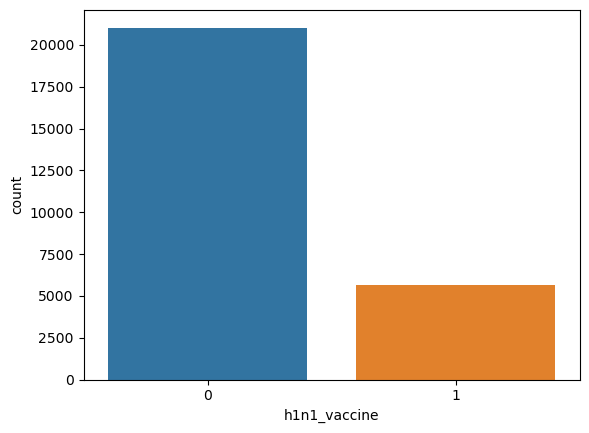

In [8]:
sns.countplot(x=df_label['h1n1_vaccine'], data=df_label)

<AxesSubplot:xlabel='seasonal_vaccine', ylabel='count'>

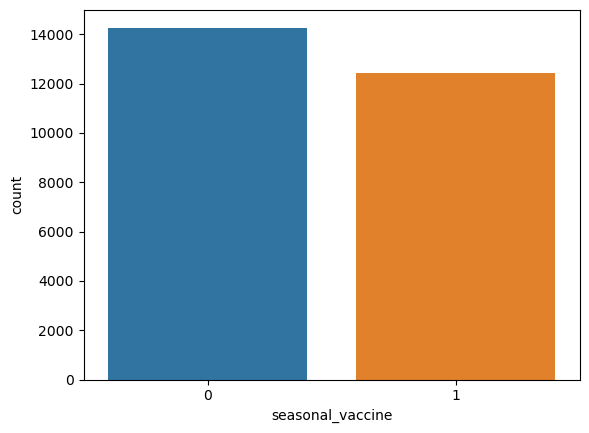

In [9]:
sns.countplot(x=df_label['seasonal_vaccine'], data=df_label)

Text(0.5, 1.0, 'Total Horsepower Bins')

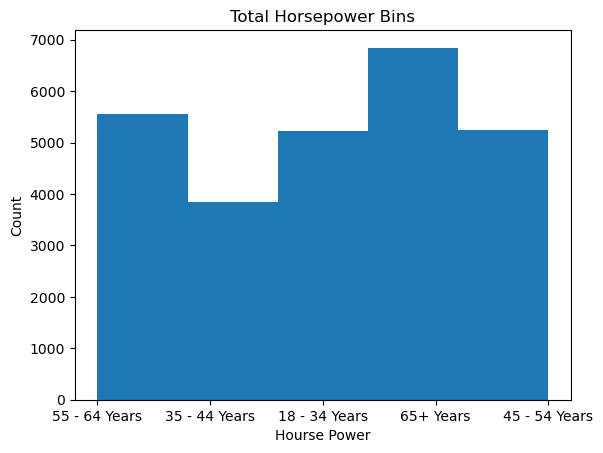

In [25]:
plt.hist(df_feature["age_group"], bins = 5)

plt.xlabel("Hourse Power")
plt.ylabel("Count")
plt.title("Total Horsepower Bins")

In [ ]:
print(df_feature['age_group'].unique())

print(df_feature['education'].unique())

print(df_feature['race'].unique())

print(df_feature['sex'].unique())

print(df_feature['income_poverty'].unique())

print(df_feature['marital_status'].unique())
print(df_feature['rent_or_own'].unique())
print(df_feature['employment_status'].unique())
print(df_feature['hhs_geo_region'].unique())
print(df_feature['census_msa'].unique())

In [ ]:
conditions = [(df_feature['age_group']=='18 - 34 Years'),(df_feature['age_group']=='35 - 44 Years'),(df_feature['age_group']=='45 - 54 Years'),(df_feature['age_group']=='55 - 64 Years'),(df_feature['age_group']=='65+ Years')]
choices = [0,1,2,3,4]
df_feature['age_qua'] = np.select(conditions,choices,default=5)

edu_conditions = [(df_feature['education'] == '< 12 Years'),(df_feature['education'] == '12 Years'),(df_feature['education'] == 'College Graduate'),(df_feature['education'] == 'Some College')]
edu_choices = [0,1,2,3]
df_feature['education_qua'] = np.select(edu_conditions,edu_choices,default=4)

race_conditions = [(df_feature['race'] == 'White'),(df_feature['race'] == 'Black'),(df_feature['race'] == 'Other or Multiple'),(df_feature['race'] == 'Hispanic')]
race_choices = [0,1,2,3]
df_feature['race_qua'] = np.select(race_conditions,race_choices,default=4)

df_feature['sex_qua'] = np.where((df_feature['sex'] == 'Male'),1,0)

income_conditions = [(df_feature['income_poverty'] == 'Below Poverty'),(df_feature['income_poverty'] == '<= $75,000, Above Poverty'),(df_feature['income_poverty'] == '> $75,000')]
income_choices = [0,1,2]
df_feature['income_qua'] = np.select(income_conditions,income_choices,default=3)

marital_conditions = [(df_feature['marital_status'] == 'Not Married'),(df_feature['marital_status'] == 'Married')]
marital_choices = [0,1]
df_feature['marital_qua'] = np.select(marital_conditions,marital_choices,default=2)

rent_conditions = [(df_feature['rent_or_own'] == 'Own'),(df_feature['rent_or_own'] == 'Rent')]
rent_choices = [0,1]
df_feature['rent_qua'] = np.select(rent_conditions,rent_choices,default=2)

employment_conditions = [(df_feature['employment_status'] == 'Not in Labor Force'),(df_feature['employment_status'] == 'Employed'),(df_feature['employment_status'] == 'Unemployed')]
employment_choices = [0,1,2]
df_feature['rent_qua'] = np.select(employment_conditions,employment_choices,default=3)

region_conditions = [df_feature['hhs_geo_region'] == 'oxchjgsf',df_feature['hhs_geo_region'] == 'bhuqouqj',df_feature['hhs_geo_region'] == 'qufhixun',df_feature['hhs_geo_region'] == 'lrircsnp',df_feature['hhs_geo_region'] == 'atmpeygn',df_feature['hhs_geo_region'] == 'lzgpxyit',df_feature['hhs_geo_region'] == 'fpwskwrf',df_feature['hhs_geo_region'] == 'mlyzmhmf',df_feature['hhs_geo_region'] == 'dqpwygqj',df_feature['hhs_geo_region'] == 'kbazzjca']
region_choices = [0,1,2,3,4,5,6,7,8,9]
df_feature['region_qua'] = np.select(region_conditions,region_choices,default=10)

msa_conditions = [(df_feature['census_msa'] == 'Non-MSA'),(df_feature['census_msa'] == 'MSA, Not Principle  City'),(df_feature['census_msa'] == 'MSA, Principle City')]
msa_choices = [0,1,2]
df_feature['msa_qua'] = np.select(msa_conditions,msa_choices,default=3)

In [ ]:
fig,axs = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_feature,x='hhs_geo_region',y='income_qua',hue='h1n1_vaccine',ax=axs)

In [ ]:
df_feature.drop(columns=['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','employment_industry','employment_occupation','health_insurance','hhs_geo_region','census_msa'],axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(25,15))
sns.heatmap(df_feature.corr(),annot=True)
plt.show()

In [ ]:
df_feature = df_feature.dropna(thresh=4)
df_feature[df_feature.isna().any(axis=1)]

In [ ]:
train_data = df_feature.dropna()

In [ ]:
imp = IterativeImputer(random_state=0,initial_strategy="most_frequent")
imp.fit(train_data)

In [ ]:
data = imp.transform(df_feature)

In [ ]:
data = data.round()

## Data Normalisation

pearson 

<AxesSubplot:xlabel='education', ylabel='Count'>

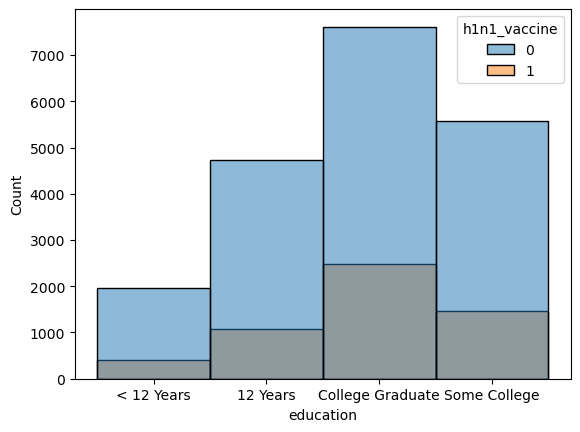

In [34]:
sns.histplot(data=df_feature,x='education',hue='h1n1_vaccine')